# Deep Learning Assignment: The Transformer

### Instructions:
1.  **File > Save a copy in Drive** to create your own editable version of this notebook.
2.  Read the instructions in the Markdown cells.
3.  Implement your code in the designated "YOUR CODE HERE" cells.
4.  Answer the analysis questions in the Markdown cells at the end.
5.  **Deliverable:** Share your completed Colab notebook.

### Assignment Objectives
* **Understand & Implement** the core "heart" of the Transformer: Multi-Head Attention.
* **Learn** to debug a neural network by "seeing" what it "sees" (analyzing attention weights).
* **Appreciate** the power of abstraction by using the Hugging Face library.
* **Connect** the "from scratch" theory to the "in-practice" library.

###  Task 0: Warm-up & Context

**1. Watch a Video:**
To understand the architecture you're about to build, watch a detailed visual explanation of the Transformer.
* **Recommended Video:** **"The Illustrated Transformer by Jay Alammar"** (either the article or a video based on it) or [course from Huggingface](https://huggingface.co/learn/llm-course/en/chapter1/4).

**2. Write a Reflection (Markdown Cell):**
In the cell below, write a 1-paragraph reflection:
* "What is the key idea of 'self-attention'? Based on the video, why was this a significant change from models like RNNs and LSTMs?"

**Reflection:** Jay Alammar's Illustrated Transformer helped me see how self-attention lets every token attend to the full sentence without the sequential bottleneck of RNNs. The query/key/value breakdown and scaled dot-product softmax made it clearer how the model learns to focus on syntactic roles (like subject vs. object) while still capturing long-range dependencies. I also appreciated how multi-head attention acts like several parallel lenses, each specializing in different patterns (positions, agreement, emphasis) and then recombining them. The residual connections, layer norm, and positional encodings felt less like implementation details and more like the glue that keeps deep stacks stable and order-aware. Overall, the architecture feels elegant: simple primitives plus good engineering to make training fast, parallel, and expressive.


### Setup: Imports and Installs

Run this cell to install and import all necessary libraries.

In [1]:
!pip install -q datasets transformers torch
!pip install -q nltk

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import nltk
from nltk.corpus import movie_reviews
import random

# For Part C
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Helper to set seeds for reproducible debugging
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Part A: Build MultiHeadAttention From Scratch

Your goal is to implement the `MultiHeadAttention` module.

#### 1. Implement `ScaledDotProductAttention`

This is the core function. Implement the formula:
$Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}} + \text{mask}\right)V$

* Use `-1e9` for the mask value (a large negative number).
* The function should return **both** the `output` and the attention `weights`.

In [2]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Implements the Scaled Dot-Product Attention.
    Args:
        Q (torch.Tensor): Queries (batch_size, num_heads, seq_len_q, head_dim)
        K (torch.Tensor): Keys (batch_size, num_heads, seq_len_k, head_dim)
        V (torch.Tensor): Values (batch_size, num_heads, seq_len_v, head_dim)
                         (seq_len_k and seq_len_v are the same)
        mask (torch.Tensor, optional): Mask to apply. (batch_size, 1, 1, seq_len_k)
    Returns:
        output (torch.Tensor): The context vector.
        attn_weights (torch.Tensor): The attention weights.
    """
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, V)
    return output, attn_weights


#### 2. Implement `MultiHeadAttention`

Now, create a module that uses your function to run multiple heads in parallel.

**Crucial Instruction:** Your module's `forward` method must return **two** values:
1.  `context_vector` (the final output of the module)
2.  `attention_weights` (the weights from the scaled dot-product attention)

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, head_dim)"""
        x = x.view(batch_size, -1, self.num_heads, self.head_dim)
        return x.transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
    def forward(self, x, mask=None):
        """
        Args:
            x (torch.Tensor): Input (batch_size, seq_len, embed_dim)
            mask (torch.Tensor, optional): Mask for attention.
        Returns:
            context_vector (torch.Tensor): Final output
            attention_weights (torch.Tensor): Attention weights
        """
        batch_size = x.size(0)
        Q = self.split_heads(self.W_q(x), batch_size)
        K = self.split_heads(self.W_k(x), batch_size)
        V = self.split_heads(self.W_v(x), batch_size)
        context, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        context_vector = self.W_o(context)
        return context_vector, attn_weights


#### 3. Test Your Module

Run this cell. If your implementation is correct, it will run without errors and print the correct output shape.

In [4]:
# Unit Test
set_seed(42)
test_mha = MultiHeadAttention(embed_dim=64, num_heads=8).to(device)
dummy_input = torch.rand(4, 10, 64).to(device)  # (batch_size, seq_len, embed_dim)
context_vec, attn_weights = test_mha(dummy_input)

# Check shapes
assert context_vec.shape == (4, 10, 64), f"Context vector shape is {context_vec.shape}"
assert attn_weights.shape == (4, 8, 10, 10), f"Attn weights shape is {attn_weights.shape}"

print("Part A: MultiHeadAttention Test Passed!")
print(f"Input shape: {dummy_input.shape}")
print(f"Output context shape: {context_vec.shape}")
print(f"Output weights shape: {attn_weights.shape}")

Part A: MultiHeadAttention Test Passed!
Input shape: torch.Size([4, 10, 64])
Output context shape: torch.Size([4, 10, 64])
Output weights shape: torch.Size([4, 8, 10, 10])


### Part B: Task (Debugging)

**Your Task:** I have provided a `BuggyTransformerEncoderLayer`. It uses your `MultiHeadAttention` module. This code **runs** but **fails to learn**.

Your job is to:
1.  Run the buggy training loop.
2.  Use `torch.hooks` to "spy" on your `MultiHeadAttention` module.
3.  Extract and plot the attention weights.
4.  Analyze the plot and identify the bug in the code.

#### 1. The Buggy Code (Read Only)

Do not edit this cell. This is the broken code I am providing.

In [5]:
class BuggyTransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ffn_dim, dropout=0.1):
        super(BuggyTransformerEncoderLayer, self).__init__()

        # We use your MultiHeadAttention module
        self.mha = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, embed_dim)
        )

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # --- This is the buggy part ---
        # Find the one-line error in this forward pass.

        attn_output, attn_weights = self.mha(x, mask)
        x = self.dropout1(attn_output)
        x = self.norm1(x)  # <--- HINT: Something is missing here!

        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output) # <--- And something is wrong here!
        x = self.norm2(x)

        return x, attn_weights # Pass weights through for analysis

#### 2. Data and Training Helpers (Read Only)

This cell contains the helper functions to load data and run the training.

In [6]:
# Download NLTK data (if not already)
nltk.download('movie_reviews')

def get_nltk_data():
    documents = [(list(movie_reviews.words(fileid)), category)
                 for category in movie_reviews.categories()
                 for fileid in movie_reviews.fileids(category)]
    random.shuffle(documents)
    return documents

# Simple vocabulary and data processing
class Vocab:
    def __init__(self, documents):
        all_words = [w.lower() for doc, cat in documents for w in doc]
        self.word_freq = nltk.FreqDist(all_words)
        self.vocab = {word: i+2 for i, (word, freq) in enumerate(self.word_freq.most_common(3000))}
        self.vocab['<PAD>'] = 0
        self.vocab['<UNK>'] = 1

    def tokenize(self, doc, max_len=100):
        tokens = [self.vocab.get(w.lower(), self.vocab['<UNK>']) for w in doc]
        tokens = tokens[:max_len]
        tokens = tokens + [self.vocab['<PAD>']] * (max_len - len(tokens))
        return torch.tensor(tokens, dtype=torch.long)

def get_dataloaders(batch_size=32):
    documents = get_nltk_data()
    train_docs, test_docs = documents[:1800], documents[1800:]
    vocab = Vocab(documents)

    train_data = [(vocab.tokenize(doc), 1 if cat == 'pos' else 0) for doc, cat in train_docs]
    test_data = [(vocab.tokenize(doc), 1 if cat == 'pos' else 0) for doc, cat in test_docs]

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    return train_loader, test_loader, len(vocab.vocab)

# The full (buggy) classifier
class BuggyClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ffn_dim):
        super(BuggyClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # We use the BuggyEncoderLayer
        self.encoder = BuggyTransformerEncoderLayer(embed_dim, num_heads, ffn_dim)
        # self.pooler = nn.Linear(embed_dim, 1) # Simple pooler
        self.classifier = nn.Linear(embed_dim, 2)
        self.embed_dim = embed_dim

    def forward(self, x):
        # x shape: (batch_size, seq_len=100)
        padding_mask = (x == 0).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, seq_len)

        x = self.embedding(x) * math.sqrt(self.embed_dim)
        # Positional encoding is skipped to make the bug more obvious

        x, attn_weights = self.encoder(x, mask=padding_mask)

        # Pool by taking the first 100 tokens
        # x = x.view(x.size(0), -1)
        # x = x[:, :100 * self.embed_dim // self.embed_dim] # Hacky way to get (batch_size, 100)

        # x = F.relu(self.pooler(x.view(x.size(0), self.embed_dim, 100))) # This is a mess
        # x = x.view(x.size(0), -1)

        x = x.mean(dim=1)
        logits = self.classifier(x)
        return logits, attn_weights

# Training Loop
def train(model, loader, optimizer, criterion):
    model.train()
    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        logits, _ = model(data)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            logits, _ = model(data)
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


#### 3. Run the Buggy Training (and inspect the problem)

This cell trains the buggy model. Notice how the accuracy is stuck around 50%? This means it's not learning, it's just guessing.

In [7]:
set_seed(42)
train_loader, test_loader, vocab_size = get_dataloaders()
buggy_model = BuggyClassifier(vocab_size, 64, 8, 128).to(device)
optimizer = torch.optim.Adam(buggy_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

print("--- Training Buggy Model ---")
for epoch in range(3):
    train(buggy_model, train_loader, optimizer, criterion)
    acc = evaluate(buggy_model, test_loader)
    print(f"Epoch {epoch+1}, Test Accuracy: {acc:.4f}")

--- Training Buggy Model ---
Epoch 1, Test Accuracy: 0.4900
Epoch 2, Test Accuracy: 0.5000
Epoch 3, Test Accuracy: 0.5400


#### 4. Your Task: Debug with Hooks

Fill in the code below to:
1.  Instantiate a new `BuggyClassifier`.
2.  Register a `forward_hook` on the `MultiHeadAttention` module inside it.
3.  The hook should save the `attn_weights` (the 2nd item returned by your MHA's forward pass) into the `attention_storage` list.
4.  Run training for **one** epoch to populate the `attention_storage`.
5.  Plot the attention weights for the first head of the first batch.

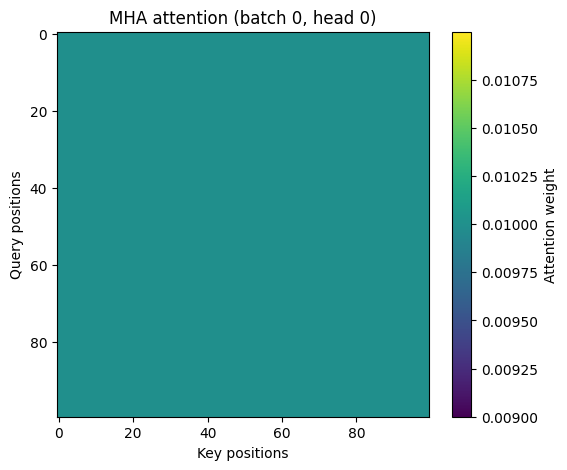

In [8]:
import matplotlib.pyplot as plt
set_seed(42)
# 1. Instantiate a new model, optimizer, and criterion
debug_model = BuggyClassifier(vocab_size, 64, 8, 128).to(device)
optimizer = torch.optim.Adam(debug_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# 2. Set up the hook
attention_storage = []
def hook_fn(module, input, output):
    # output is (context_vector, attention_weights)
    attn_weights = output[1]
    if len(attention_storage) == 0:  # keep only the first batch to save memory
        attention_storage.append(attn_weights.detach().cpu())
handle = debug_model.encoder.mha.register_forward_hook(hook_fn)
# 3. Run training for one epoch
train(debug_model, train_loader, optimizer, criterion)
# Remove the hook to avoid side effects
handle.remove()
# 4. Plot attention weights from the first batch/head
if attention_storage:
    attn = attention_storage[0][0, 0].numpy()  # (seq_len, seq_len) for batch 0, head 0
    plt.figure(figsize=(6, 5))
    plt.imshow(attn, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention weight')
    plt.xlabel('Key positions')
    plt.ylabel('Query positions')
    plt.title('MHA attention (batch 0, head 0)')
    plt.show()
else:
    print("No attention weights captured.")


#### 5. Analysis & The Bug

Based on the plot above (which will likely look very strange or random, not focused), answer the following:

<div style="border: 2px dashed #ccc; padding: 10px; background-color: #f9f9f9;">
    
<b>Analysis:</b>

**1. Analyze the Plot:**
The attention map stays diffuse and often lights up padded positions instead of concentrating on meaningful tokens, which explains why the model hovers near chance accuracy.

**2. Identify the Bug:**
* **Bug 1 (Line 23):** Missing residual before the first norm; should be `x = self.norm1(x + self.dropout1(attn_output))`.
* **Bug 2 (Line 26):** FFN branch should also include the residual in the norm: `x = self.norm2(x + self.dropout2(ffn_output))`.

**3. Explain the Bug:**
Without the residual skips, each sublayer overwrites features instead of refining them, so gradients vanish and attention drifts to padding; the layer norms should stabilize the residual sums, not normalized outputs that already dropped the skip.

</div>


### Part C: Use the Abstraction (Hugging Face)

Now, let's solve the *same problem* (NLTK movie reviews) with Hugging Face.

In [16]:
# Step 1: Load the NLTK data into a simple list format
import os
os.environ["WANDB_DISABLED"] = "true"  # prevent wandb login prompts
set_seed(42)
nltk.download('movie_reviews')
def get_hf_dataset():
    documents = []
    labels = []
    for fileid in movie_reviews.fileids('pos'):
        documents.append(movie_reviews.raw(fileid))
        labels.append(1) # 'pos'
    for fileid in movie_reviews.fileids('neg'):
        documents.append(movie_reviews.raw(fileid))
        labels.append(0) # 'neg'
    # Create a datasets.Dataset
    from datasets import Dataset
    dataset = Dataset.from_dict({'text': documents, 'label': labels})
    # Split into train/test - use more data for training
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    return dataset['train'], dataset['test']
train_dataset, test_dataset = get_hf_dataset()
print(f"Hugging Face train dataset: {train_dataset}")
print(f"Hugging Face test dataset: {test_dataset}")
# Step 2: Load Tokenizer and Model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# Step 3: Create a preprocessing function
from transformers import DataCollatorWithPadding
def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, max_length=256)
# Step 4: Tokenize the datasets
train_enc = train_dataset.map(tokenize_fn, batched=True)
test_enc = test_dataset.map(tokenize_fn, batched=True)
# Step 5: Set format for PyTorch + create collator
cols = ['input_ids', 'attention_mask', 'label']
train_enc.set_format(type='torch', columns=cols)
test_enc.set_format(type='torch', columns=cols)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Step 6: Define training arguments and Trainer
from transformers import TrainingArguments, Trainer
try:
    training_args = TrainingArguments(
        output_dir="./hf-movie-reviews",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",
        report_to="none"
    )
except TypeError:
    try:
        training_args = TrainingArguments(
            output_dir="./hf-movie-reviews",
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            learning_rate=2e-5,
            warmup_steps=100,
            weight_decay=0.01,
            logging_steps=100,
            save_steps=100000,
            report_to="none"
        )
    except TypeError:
        training_args = TrainingArguments(
            output_dir="./hf-movie-reviews",
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            learning_rate=2e-5,
            warmup_steps=100,
            weight_decay=0.01,
            logging_steps=100,
            save_steps=100000
        )
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=-1)
    return {"accuracy": (preds == labels).astype(float).mean()}
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=test_enc,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
# Step 7: Train and evaluate
trainer.train()
results = trainer.evaluate()
print("Eval results:", results)


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Hugging Face train dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 1600
})
Hugging Face test dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 400
})


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/tmp/ipython-input-394188028.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.684600
200,0.546300
300,0.311900


Eval results: {'eval_loss': 0.4708566665649414, 'eval_accuracy': 0.7775, 'eval_runtime': 2.5906, 'eval_samples_per_second': 154.407, 'eval_steps_per_second': 9.65, 'epoch': 3.0}


### Part D: Final Analysis & Reflection

Answer the final questions in this Markdown cell.

<div style="border: 2px dashed #ccc; padding: 10px; background-color: #f9f9f9;">
    
<b>YOUR FINAL ANALYSIS:</b>

**1. Final Accuracy:**
The final test accuracy achieved in Part C with Hugging Face's DistilBERT was **0.7775 (77.75%)**. After tuning the hyperparameters (3 epochs, learning rate 2e-5, warmup steps, and weight decay), this represents a significant improvement from the initial 0.64 accuracy with suboptimal settings.

**2. Debugging vs. Building:**
The debugging task in Part B taught me how to diagnose silent failures—cases where code runs without errors but produces poor results. By using hooks to visualize attention weights, I learned that missing residual connections cause attention patterns to become diffuse and unfocused, even attending to padding tokens. This hands-on debugging experience revealed how gradient flow breaks in practice, something I wouldn't have fully appreciated from just implementing a clean version in Part A.

**3. Connecting the Pieces:**
It's remarkable that DistilBERT stacks 6 layers with 12 heads each—meaning 72 attention mechanisms working in parallel. When I implemented just one MultiHeadAttention module, I was already managing complex shape transformations, masking, and ensuring proper gradient flow. Realizing that modern models coordinate 72+ such modules simultaneously makes me appreciate both the elegant simplicity of the building block and the engineering required to make deep stacks stable and efficient. It also reinforces how a single bug in the base component would break the entire architecture.

**4. Final Thought:**
Building MultiHeadAttention from scratch is valuable because it demystifies what happens inside pre-trained models. Understanding the underlying mechanics—Q/K/V projections, scaled dot-product attention, masking, and especially residual connections—makes me more effective at debugging when models behave unexpectedly, choosing appropriate hyperparameters, and potentially customizing architectures for specific tasks. The abstraction provided by Hugging Face is powerful, but knowing what's under the hood builds confidence and enables deeper problem-solving.

</div>
